In [42]:
from disease_prediction.data import datasets as ds
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi'] = 200

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Loading data and cleaning/preprocessing

In [2]:
directory = '../disease_prediction/data/'

df = ds.load_datasets(subsets=['train', 'validate', 'test'],
                      directory=directory)

df_train = pd.concat([df['train'], df['validate']],
                     axis=0,
                     ignore_index=True)


In [10]:
total = df['test'].shape[0] + df_train.shape[0]
test_frac = df['test'].shape[0] / total
print('the test set contains {:.1f} percent of the the data'.format(test_frac*100))

the test set contains 10.1 percent of the the data


In [11]:
## removing lesion_peeling, pain_radiate columns
df_train.drop(columns=['lesions_peeling', 'pain_radiate'], inplace=True)


## one hot encoding for all categorical features
categorical_features=df_train.select_dtypes(include='object').columns.tolist()

categorical_features.remove('PATHOLOGY')
categorical_features.remove('pain_somewhere')
categorical_features.remove('lesion_location')

df_train = pd.get_dummies(df_train,
                          columns=categorical_features,
                          dtype=int)


df_train['lesion_location'] = (df_train['lesion_location'] != 'nowhere').astype(int)
df_train['pain_somewhere'] = (df_train['pain_somewhere'] != 'nowhere').astype(int)

# Splitting the data

In [12]:
X = df_train.drop(columns=['PATHOLOGY', 'index'])
y = df_train.PATHOLOGY

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  shuffle=True,
                                                  random_state=740)

# Baseline model

- this is a frequency based model --> we predict the highest frequency pathology in our training set every time.
- in our case, this was HIV.

In [15]:
most_frequent = y_train.value_counts().index[0]
print('Most frequent disease is', most_frequent)

y_pred = [most_frequent]*len(y_val)
print(classification_report(y_val, y_pred))

Most frequent disease is HIV (initial infection)
                         precision    recall  f1-score   support

     Allergic sinusitis       0.00      0.00      0.00      5754
            Anaphylaxis       0.00      0.00      0.00      6201
                 Chagas       0.00      0.00      0.00      2039
HIV (initial infection)       0.14      1.00      0.25      6536
              Influenza       0.00      0.00      0.00      6121
        Localized edema       0.00      0.00      0.00      6277
                    SLE       0.00      0.00      0.00      2714
            Sarcoidosis       0.00      0.00      0.00      4788
           Tuberculosis       0.00      0.00      0.00      3818
         Whooping cough       0.00      0.00      0.00      1272

               accuracy                           0.14     45520
              macro avg       0.01      0.10      0.03     45520
           weighted avg       0.02      0.14      0.04     45520



# Simple Decision Tree model

In [22]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_val)
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

     Allergic sinusitis       0.81      0.88      0.85      5754
            Anaphylaxis       0.63      0.52      0.57      6201
                 Chagas       0.60      0.26      0.36      2039
HIV (initial infection)       0.41      0.43      0.42      6536
              Influenza       0.54      0.34      0.42      6121
        Localized edema       0.54      0.92      0.68      6277
                    SLE       0.58      0.37      0.45      2714
            Sarcoidosis       0.60      0.63      0.62      4788
           Tuberculosis       0.53      0.50      0.51      3818
         Whooping cough       1.00      1.00      1.00      1272

               accuracy                           0.59     45520
              macro avg       0.62      0.59      0.59     45520
           weighted avg       0.59      0.59      0.57     45520



# XGBoost model

In [27]:
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight

y_train_int = y_train.astype('category').cat.codes
y_val_int = y_val.astype('category').cat.codes

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [29]:
xgb_clf = XGBClassifier(objective='multi:softmax', 
                                missing=-999, 
                                seed=42, 
                                learning_rate=0.1,
                                early_stopping_rounds = 20)

xgb_clf = xgb_clf.fit(X_train,
                      y_train_int, 
                      verbose=True, 
                      sample_weight=sample_weights,
                      eval_set = [(X_val, y_val_int)])

y_pred = xgb_clf.predict(X_val)

[0]	validation_0-mlogloss:2.08183
[1]	validation_0-mlogloss:1.93518
[2]	validation_0-mlogloss:1.82340
[3]	validation_0-mlogloss:1.73309
[4]	validation_0-mlogloss:1.65796
[5]	validation_0-mlogloss:1.59308
[6]	validation_0-mlogloss:1.53730
[7]	validation_0-mlogloss:1.48866
[8]	validation_0-mlogloss:1.44508
[9]	validation_0-mlogloss:1.40614
[10]	validation_0-mlogloss:1.37134
[11]	validation_0-mlogloss:1.33939
[12]	validation_0-mlogloss:1.31044
[13]	validation_0-mlogloss:1.28399
[14]	validation_0-mlogloss:1.25965
[15]	validation_0-mlogloss:1.23756
[16]	validation_0-mlogloss:1.21706
[17]	validation_0-mlogloss:1.19828
[18]	validation_0-mlogloss:1.18064
[19]	validation_0-mlogloss:1.16435
[20]	validation_0-mlogloss:1.14915
[21]	validation_0-mlogloss:1.13496
[22]	validation_0-mlogloss:1.12169
[23]	validation_0-mlogloss:1.10939
[24]	validation_0-mlogloss:1.09765
[25]	validation_0-mlogloss:1.08664
[26]	validation_0-mlogloss:1.07650
[27]	validation_0-mlogloss:1.06669
[28]	validation_0-mlogloss:1.0

In [30]:
print(classification_report(y_val_int, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      5754
           1       1.00      0.40      0.57      6201
           2       0.35      0.45      0.39      2039
           3       0.55      0.09      0.15      6536
           4       0.63      0.40      0.49      6121
           5       0.52      1.00      0.69      6277
           6       0.31      0.72      0.43      2714
           7       0.74      0.56      0.64      4788
           8       0.46      0.83      0.59      3818
           9       1.00      1.00      1.00      1272

    accuracy                           0.58     45520
   macro avg       0.65      0.63      0.58     45520
weighted avg       0.66      0.58      0.56     45520



# Random Forest model

In [31]:
from sklearn.ensemble import RandomForestClassifier

## optimal model hyperparameters
n_estimators = 500
max_depth = 20
min_samples_leaf = 5
bootstrap = False

rf_prelim = RandomForestClassifier(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_leaf=min_samples_leaf,
    bootstrap=bootstrap
)

rf_prelim.fit(X_train, y_train)
pred_prelim = rf_prelim.predict(X_val)
print(classification_report(y_val, pred_prelim, 
                            digits=4, output_dict=False))

                         precision    recall  f1-score   support

     Allergic sinusitis     0.8553    0.8783    0.8667      5754
            Anaphylaxis     0.9278    0.4061    0.5649      6201
                 Chagas     1.0000    0.2281    0.3714      2039
HIV (initial infection)     0.3927    0.6841    0.4990      6536
              Influenza     0.7292    0.2438    0.3654      6121
        Localized edema     0.5231    1.0000    0.6869      6277
                    SLE     1.0000    0.2977    0.4588      2714
            Sarcoidosis     0.5737    0.7097    0.6345      4788
           Tuberculosis     0.5807    0.4560    0.5109      3818
         Whooping cough     1.0000    1.0000    1.0000      1272

               accuracy                         0.6040     45520
              macro avg     0.7583    0.5904    0.5958     45520
           weighted avg     0.7025    0.6040    0.5835     45520



# Comparison plots

In [32]:
precisions = {'baseline': 0.01,
              'decision tree': 0.62,
              'xgboost': 0.65,
              'random forest': 0.7583}

recalls = {'baseline': 0.1,
              'decision tree': 0.59,
              'xgboost': 0.63,
              'random forest': 0.5904}

f1s = {'baseline': 0.03,
              'decision tree': 0.59,
              'xgboost': 0.58,
              'random forest': 0.5958}

In [37]:
performances = pd.DataFrame([precisions, recalls, f1s], index=['precision', 'recall', 'f1-score'])

In [38]:
performances.head()

,baseline,decision tree,xgboost,random forest
precision,0.01,0.62,0.65,0.7583
recall,0.10,0.59,0.63,0.5904
f1-score,0.03,0.59,0.58,0.5958


In [49]:
df_melted = performances.reset_index().melt(id_vars='index', var_name='Model', value_name='Score')
df_melted.rename(columns={'index': 'Metric'}, inplace=True)
df_melted['Score'] = df_melted.Score*100

Text(0.5, 0, 'Score %')

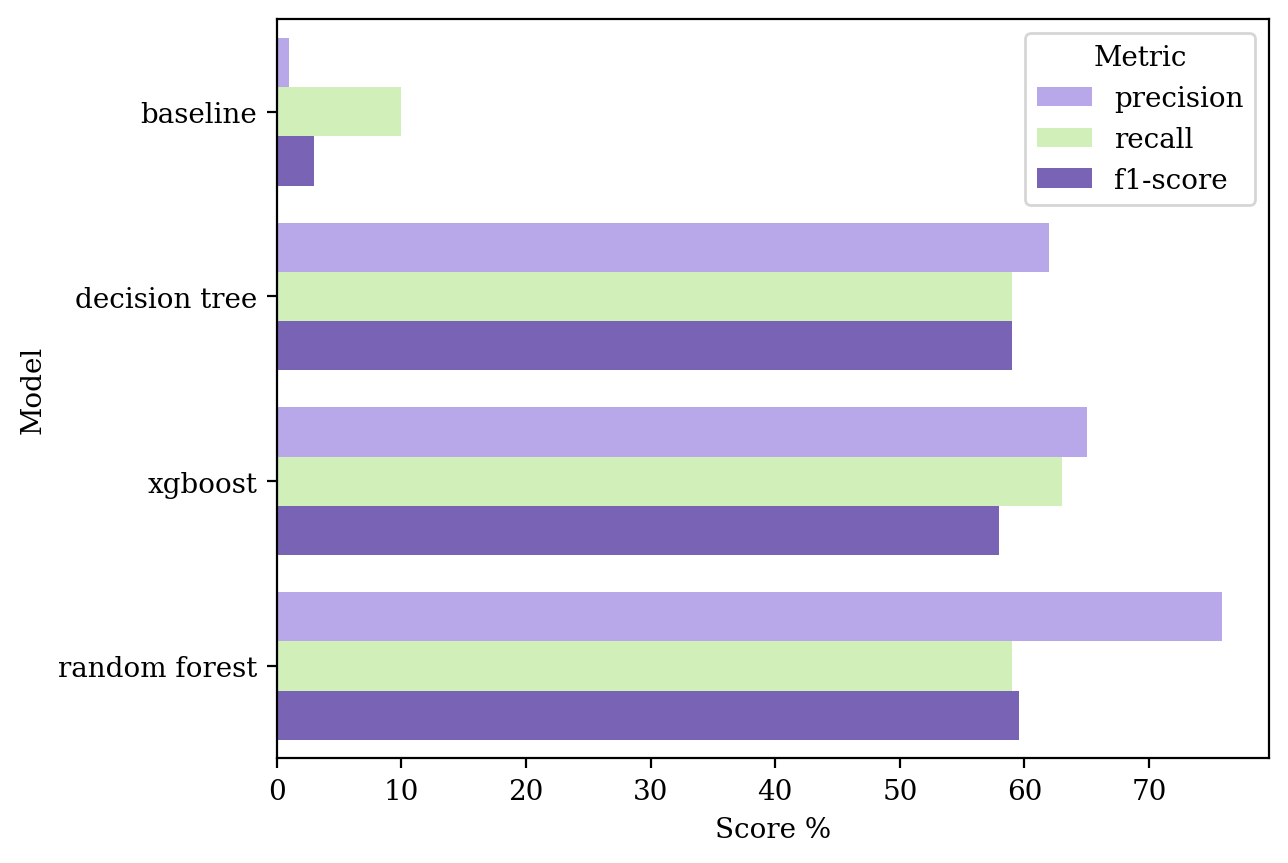

In [51]:
sns.barplot(data=df_melted, x='Score', y='Model', hue='Metric',
            palette=['#B29CF4', '#CEF8B0', '#7155C2'])
plt.xlabel('Score %')

# Feature importance

In [52]:
feat_importances = pd.Series(rf_prelim.feature_importances_, index=X_train.columns)

In [65]:
feat_importances.sort_values(ascending=False)[:20].index

Index(['INITIAL_EVIDENCE_swelling', 'INITIAL_EVIDENCE_itchy_nose',
       'INITIAL_EVIDENCE_runny_nose', 'INITIAL_EVIDENCE_eye_itching',
       'INITIAL_EVIDENCE_gained_weight', 'INITIAL_EVIDENCE_cough_blood',
       'INITIAL_EVIDENCE_cough', 'INITIAL_EVIDENCE_vomiting_cough',
       'INITIAL_EVIDENCE_pain', 'INITIAL_EVIDENCE_convulsion',
       'INITIAL_EVIDENCE_red_eye', 'INITIAL_EVIDENCE_swollen_nodes',
       'INITIAL_EVIDENCE_contact_allergy', 'INITIAL_EVIDENCE_vag_discharge',
       'INITIAL_EVIDENCE_short_breath', 'INITIAL_EVIDENCE_ulcers',
       'INITIAL_EVIDENCE_chills', 'INITIAL_EVIDENCE_weight_loss',
       'INITIAL_EVIDENCE_dizziness', 'INITIAL_EVIDENCE_stridor'],
      dtype='object')

<Axes: xlabel='None', ylabel='None'>

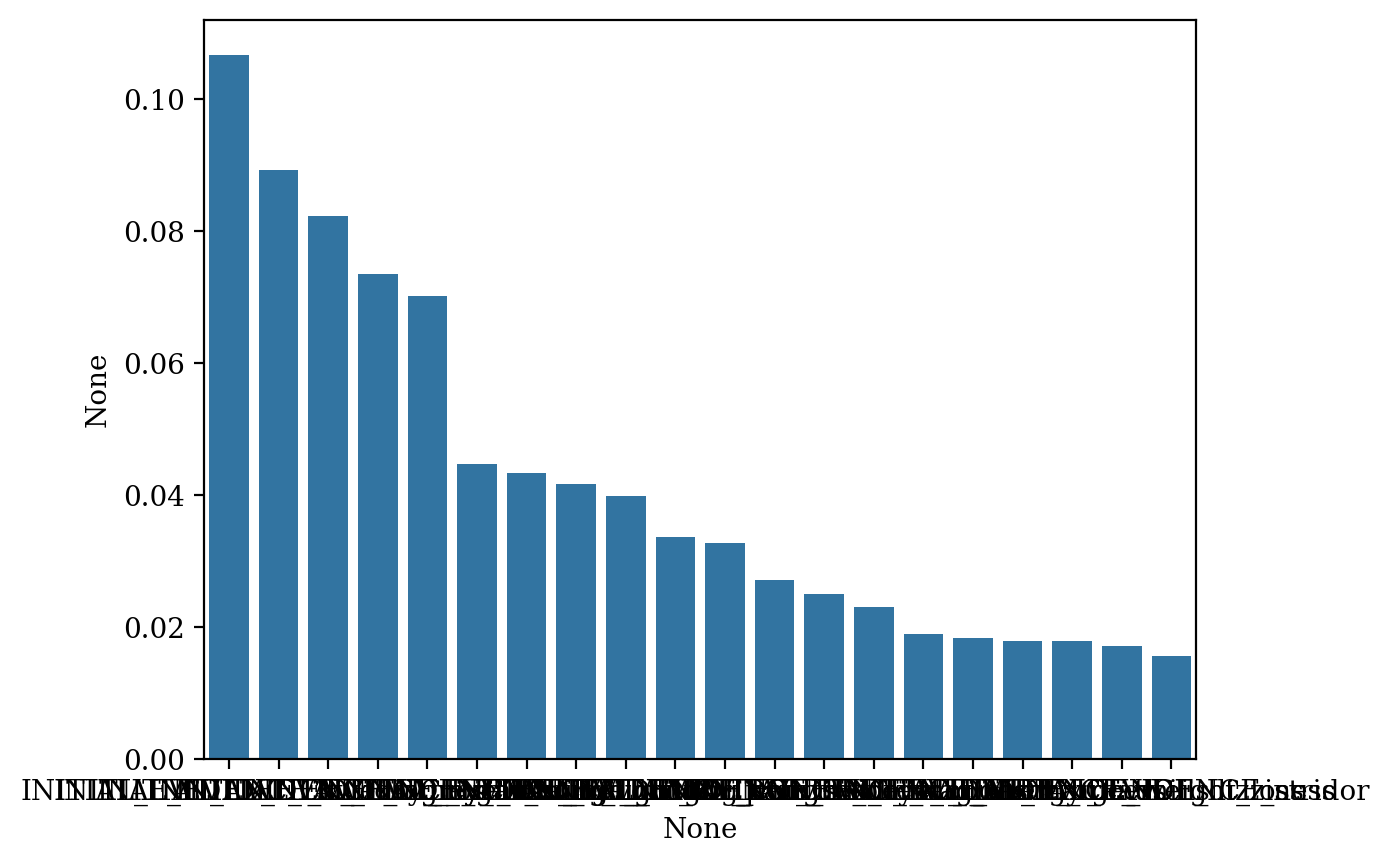

In [66]:
sns.barplot(y=feat_importances.sort_values(ascending=False)[:20], x=feat_importances.sort_values(ascending=False)[:20].index)